# Classification of Iris Data Set

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn import Linear, Sequential
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import pandas as pd

## Reproducibility the results

In [2]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  #if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(123)

## Loading the Iris Data Set

In [3]:
iris = load_iris()
#print(iris)

## Now we will process the Iris Data Set

In [4]:
features = iris.data
#print(features)
target = iris.target
#print(len(target))

## Split the Data Set

In [5]:
#splitting to 20% test 80% train
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

## Now we will standardize the values 

In [6]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
features_count = x_train.shape[1]
#print(features_count)
classes = len(np.unique(target))
#print(classes)

## Converting them into Pytorch Tensors

In [7]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Building up the model 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dnn_model = Sequential(Linear(features_count,10), nn.ReLU(),
                       Linear(10,20), nn.ReLU(),
                       Linear(20,15), nn.ReLU(),
                       Linear(15, classes)).to(device)

# Computing loss 

In [9]:
def compute_loss(model, loss_fn, x_data, y_data, device):
    model.eval()
    x_data, y_data = x_data.to(device), y_data.to(device)
    with torch.no_grad(): 
        outputs = model(x_data)
        loss = loss_fn(outputs, y_data)
    return float(loss)

# Computing accuracy

In [10]:
def compute_acc(model, X_data, y_data, device):
    model.eval() #Evaluation Model
    with torch.no_grad(): #Disable gradient calculation to save computation energy 
        X_data, y_data = X_data.to(device), y_data.to(device)
        #use the model to predict the results
        outputs = model(X_data.type(torch.float32))  
        #note that due to crossentropy function to calculate loss, the softmax is already included as it parts of calculation
        #even if they dont sum to 1
        #choose the highest probability for each row so it belongs to the certain class
        predicted = torch.argmax(outputs.data, 1)
        corrects = (predicted == y_data.type(torch.long)).sum().item()
        incorrects = (predicted != y_data.type(torch.long)).sum().item()
        totals = y_data.size(0)
        acc = float(corrects) / totals
    return acc


## Function to create model 

In [11]:
def create_model():
	dnn_model = Sequential(Linear(features_count,10), nn.ReLU(),
                         Linear(10,20), nn.ReLU(),
                         Linear(20,15), nn.ReLU(),
                         Linear(15, classes))
	return dnn_model

## Training model 

In [12]:
def fit(model=None, X_train=None, y_train=None, loss_fn=None, optimizer=torch.optim.Adam,
        learning_rate=0.001, num_epochs=100, verbose=True, seed=123, device=None):
    torch.manual_seed(seed)
    optim = optimizer(model.parameters(), lr=learning_rate)
    history = dict()
    history['train_loss'] = []
    history['train_acc'] = []

    # Move data to device
    X_train, y_train = X_train.to(device), y_train.to(device)

    for epoch in range(num_epochs):
        #allow the model to go in training mode
        model.train()
        
        #foward propaogation
        outputs = model(X_train.type(torch.float32))
        #the softmax cross entropy
        loss = loss_fn(outputs, y_train.type(torch.long))
        #print(loss)
        
        #make sure the gradient computed is zero so it doesnt accumulate from previous iteration
        optim.zero_grad()
        #conpute the gradient lost
        loss.backward()
        #update the weights and bias
        optim.step()

        #evaluate the accuracy for this current epoch
        model.eval()  # Set the model to evaluation mode
        train_loss = compute_loss(model, loss_fn, X_train, y_train, device)
        train_acc = compute_acc(model, X_train, y_train, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}%")

    return history

## Training model and choosing the optimiser 

In [13]:
from torch import optim
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}


dnn_model = create_model().to(device)
history = fit(dnn_model, X_train = x_train_tensor, y_train=y_train_tensor, loss_fn = nn.CrossEntropyLoss(),
    optimizer = optim_dict["SGD"], learning_rate = 0.15, num_epochs = 60, verbose= True, seed=101, device=device)


Epoch 1/60
train loss= 1.0970 - train acc= 36.67%
Epoch 2/60
train loss= 1.0923 - train acc= 36.67%
Epoch 3/60
train loss= 1.0879 - train acc= 36.67%
Epoch 4/60
train loss= 1.0838 - train acc= 36.67%
Epoch 5/60
train loss= 1.0798 - train acc= 36.67%
Epoch 6/60
train loss= 1.0758 - train acc= 36.67%
Epoch 7/60
train loss= 1.0718 - train acc= 36.67%
Epoch 8/60
train loss= 1.0678 - train acc= 36.67%
Epoch 9/60
train loss= 1.0637 - train acc= 36.67%
Epoch 10/60
train loss= 1.0594 - train acc= 36.67%
Epoch 11/60
train loss= 1.0549 - train acc= 37.50%
Epoch 12/60
train loss= 1.0501 - train acc= 41.67%
Epoch 13/60
train loss= 1.0448 - train acc= 53.33%
Epoch 14/60
train loss= 1.0392 - train acc= 58.33%
Epoch 15/60
train loss= 1.0330 - train acc= 62.50%
Epoch 16/60
train loss= 1.0262 - train acc= 64.17%
Epoch 17/60
train loss= 1.0188 - train acc= 65.00%
Epoch 18/60
train loss= 1.0105 - train acc= 65.83%
Epoch 19/60
train loss= 1.0013 - train acc= 65.83%
Epoch 20/60
train loss= 0.9912 - train a

In [14]:
print(dnn_model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=3, bias=True)
)


## Testing the model

In [15]:
def compute_wrong(model, X_data, y_data, device):
    model.eval() #Evaluation Model
    with torch.no_grad(): #Disable gradient calculation to save computation energy 
        X_data, y_data = X_data.to(device), y_data.to(device)
        #use the model to predict the results
        outputs = model(X_data.type(torch.float32))  
        #choose the highest probability for each row so it belongs to the certain class
        predicted = torch.argmax(outputs.data, 1)
        #print("Actual:   ", y_data)
        #print("Predicted:", predicted)
        corrects = (predicted == y_data.type(torch.long)).sum().item()
        incorrects = (predicted != y_data.type(torch.long)).sum().item()
        totals = y_data.size(0)
        acc = float(corrects) / totals
        #0 = Iris Setosa, 1 = Iris Versicolor , 2 = Iris Virginica
        for i in range(len(y_data)):
            if predicted[i] != y_data[i]:
                #if we predict it is setosa
                if predicted[i] == 0:
                    if y_data[i] == 1:
                        print("Predicted : Iris Setosa", "|| Correct : Iris Versicolor")
                    
                    else:
                        print("Predicted : Iris Setosa", "|| Correct : Iris Virginica")
                        
                #if we predict it is versicolor
                elif predicted[i] == 1:
                    if y_data[i] == 0:
                        print("Predicted : Iris Versicolor ", "|| Correct : Iris Setosa")
                    
                    else:
                        print("Predicted : Iris Versicolor", "|| Correct : Iris Virginica")
                #if we predict it is virginica
                else:
                    if y_data[i] == 0:
                        print("Predicted : Iris Virginica", "|| Correct : Iris Setosa")
                    
                    else:
                        print("Predicted : Iris Virginica", "|| Correct : Iris Versicolor")
        
                    
        
    return acc

In [16]:
test_accuracy = compute_wrong(dnn_model, x_test_tensor, y_test_tensor, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Versicolor || Correct : Iris Virginica
Predicted : Iris Versicolor || Correct : Iris Virginica
Predicted : Iris Versicolor || Correct : Iris Virginica
Test Accuracy: 86.67%


We can pretty much see that the model is having a hard time differentiating between Iris Virginica and Iris Versicolor, this might be caused by the similaries of petal length, petal width and speal length and sepal width.

# Testing Stage

Now we want to investigate whether if the number of epoch would affect the accuracy and how would the time be affected too and also using one layer for experiment. As our data set is quite simple, we want to know whether if 1 hidden layer is sufficient.

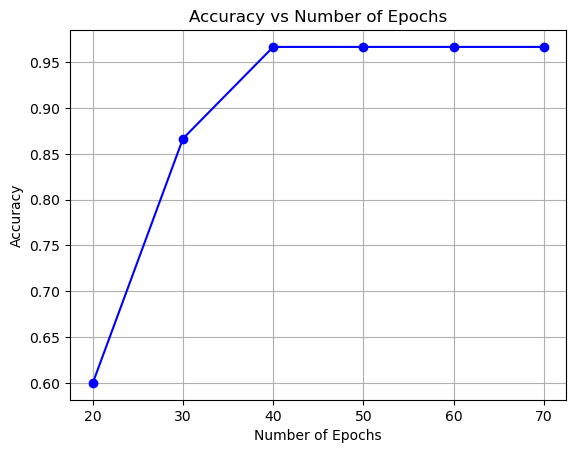

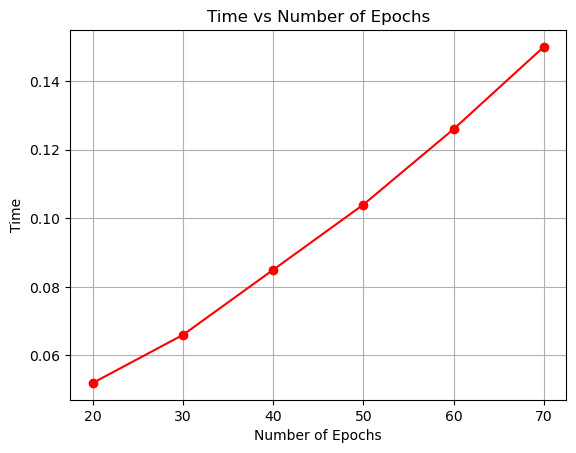

In [17]:
import time
def number_of_epoches():
    accuracy_hist = []
    time_taken = []
    num_epoch = [20,30,40,50,60,70]
    dnn_model = Sequential(Linear(features_count,10), nn.ReLU(),
                         Linear(10,20), nn.ReLU(),
                         Linear(20,15), nn.ReLU(),
                         Linear(15, classes))
    
    for epochs in num_epoch:
        starttime  = time.time()
        history = fit(dnn_model, X_train=x_train_tensor, y_train=y_train_tensor, loss_fn=nn.CrossEntropyLoss(),
                      optimizer=optim_dict["SGD"], learning_rate=0.1, num_epochs=epochs, verbose=False, seed=101, device=device)
        endtime = time.time()
        elapsed_time = endtime - starttime
        time_taken.append(elapsed_time)
        
        #saving the accuracies
        accuracy_hist.append(compute_acc(dnn_model, x_test_tensor, y_test_tensor, device))
    
    
    #plotting for Accuracy vs Epoch
    plt.plot(num_epoch, accuracy_hist, 'bo-', label="Accuracy vs Number of Epochs")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of Epochs")
    plt.grid(True)
    plt.show()
    
    #plotting for Time vs Neurons
    plt.plot(num_epoch, time_taken, 'ro-', label="Time vs Number of Epochs")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Time")
    plt.title("Time vs Number of Epochs")
    plt.grid(True)
    plt.show()
    
    
    return None
    
number_of_epoches() 

Now we want to see if we can reduce the computation energy by reducing the hidden layer to one.

## Now we want to use different sets of seed to see if the accuracy is consistent

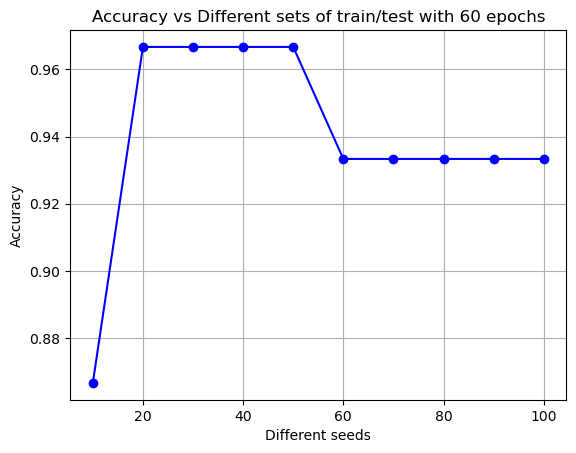

In [18]:
#we want to add the random state to the splitting to have different data splitted
def different_seed(): 
    random_seeds = [10,20,30,40,50,60,70,80,90,100]
    accuracy_hist = []
    dnn_model = Sequential(Linear(features_count,10), nn.ReLU(),
             Linear(10,20), nn.ReLU(),
             Linear(20,15), nn.ReLU(),
             Linear(15, classes))
    for i in random_seeds:
        x_train2, x_test2, y_train2, y_test2 = train_test_split(features, target, test_size=0.2, random_state=i)
        history = fit(dnn_model, X_train=x_train_tensor, y_train=y_train_tensor, loss_fn=nn.CrossEntropyLoss(),
                      optimizer=optim_dict["SGD"], learning_rate=0.1, num_epochs=60, verbose=False, seed=101, device=device)
        #saving the accuracies
        accuracy_hist.append(compute_acc(dnn_model, x_test_tensor, y_test_tensor, device))
        
    
    #plotting random seed against accuracy
    plt.plot(random_seeds, accuracy_hist, 'bo-', label="Accuracy vs Different sets of train/test")
    plt.xlabel("Different seeds")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Different sets of train/test with 60 epochs")
    plt.grid(True)
    plt.show()
    
    return None

different_seed()

As we can see, the accuracy ranges about 0.87 to 0.97, but it is consistantly hitting between 0.92 and 0.97 which is good.

## With one hidden layer only

In [19]:
def create_model_one_layer():
	dnn_model = Sequential(Linear(features_count,10), nn.ReLU(),
                         Linear(10, classes))
	return dnn_model

In [20]:
dnn_model = create_model_one_layer().to(device)
history = fit(dnn_model, X_train = x_train_tensor, y_train=y_train_tensor, loss_fn = nn.CrossEntropyLoss(),
optimizer = optim_dict["SGD"], learning_rate = 0.1, num_epochs = 60, verbose= False, seed=101, device=device)


In [21]:
test_accuracy = compute_wrong(dnn_model, x_test_tensor, y_test_tensor, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Predicted : Iris Versicolor || Correct : Iris Virginica
Test Accuracy: 96.67%


We can see that even with one layer, we could still perform well this is mainly due to the simplicity of the Iris Data Sets, we could conserve computation energy by just using one layer. However, we need to consider that it is almost **not optimal for using a single layer in Neural network** as we need to consider that **non-linearlity of data points** for many other data sets. If we only use a single layer, it would have limited representation power make it almost impossible to use with other kinds of data sets during our future work.

&nbsp;

Now we want to see how the **number of neurons** for a layer affect the accuracies and the time for computation.

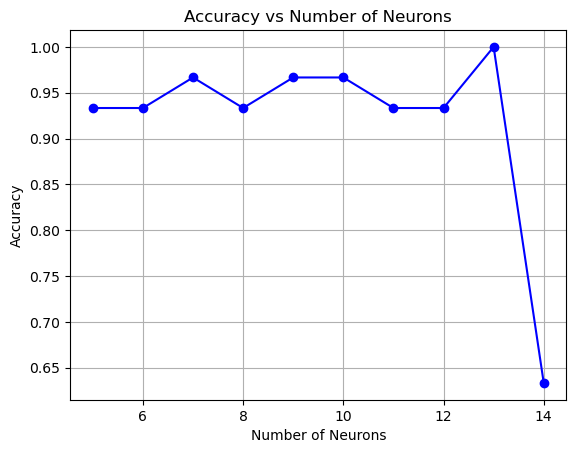

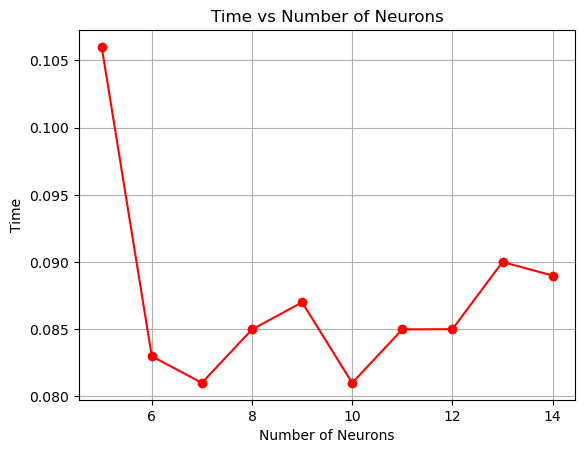

In [22]:
import time
def number_of_neurons_a_layer():
    accuracy_hist = []
    time_taken = []
    num_neurons = []
    models = []
    for i in range(5,15):
        num_neurons.append(i)
        models.append(Sequential(Linear(features_count, 5), nn.ReLU(), Linear(5, classes)))
    
    for model in models:
        starttime  = time.time()
        history = fit(model, X_train=x_train_tensor, y_train=y_train_tensor, loss_fn=nn.CrossEntropyLoss(),
                      optimizer=optim_dict["SGD"], learning_rate=0.1, num_epochs=60, verbose=False, seed=200, device=device)
        endtime = time.time()
        elapsed_time = endtime - starttime
        time_taken.append(elapsed_time)
        
        #saving the accuracies
        accuracy_hist.append(compute_acc(model, x_test_tensor, y_test_tensor, device))
    
    
    #plotting for Accuracy vs Neurons
    plt.plot(num_neurons, accuracy_hist, 'bo-', label="Accuracy vs Number of Neurons")
    plt.xlabel("Number of Neurons")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of Neurons")
    plt.grid(True)
    plt.show()
    
    #plotting for Time vs Neurons
    plt.plot(num_neurons, time_taken, 'ro-', label="Accuracy vs Number of Neurons")
    plt.xlabel("Number of Neurons")
    plt.ylabel("Time") 
    plt.title("Time vs Number of Neurons")
    plt.grid(True)
    plt.show()
    
    
    return None
    
number_of_neurons_a_layer() 

As we can see, most of the time, with higher number of neurons, we are able to get higher accuracies, however, the time needed for computation also increases which is a trade off. This is due to more number of neurons would be able to **learn more complex patterns** , **avoids underfitting** and also **introduce more non-linear combinations learning**. However, we can cearly see that if the neuron numbers are too large, it might cause it to perform badly on unseen data due to overfitting to training data.

 ## Now we will try changing the final activation function to Sigmoid

We would create something called OneVersusAllLoss as we are using sigmoid for multiclass classification problem. What we do is we basically build a custom foward propagation for our model.
The details are as follows:
- Now we are using the `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as what we did for the previous models to obtain $p = [p_1, p_2,...,p_M]$ which sums up to 1, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Where $M$ is the number of classes which is 3 here.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ to be predicted as 1 and to minimize the likelihoods $p_i, i \neq y$. So what we need to do is:
  - $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.


In [23]:
class OneVersusAllLoss(nn.Module):
    def forward(self, predictions, targets):
        #converts the outputs from logits to sigmoids probs
        probabilities = torch.sigmoid(predictions)
        
        #encoding the targets so they are one hot encoded
        #create the place holder
        targets_one_hot = torch.zeros_like(probabilities)
        
        #after changing the dimension of the targets to (batch,1)
        #we would then place all of the 1 in the acording place by the (batch,1)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        
        #we need to calculate the probability for the positive, the correct class
        log_prob_py = torch.log(probabilities + 1e-10) #avoiding log 0
        
        #only extract the true class, if multiply other class which is 0 will give 0
        log_probs_true = torch.sum(targets_one_hot * log_prob_py, dim=1)
    
        #now we need to extract the negative class excluding the positive class
        log_nonpy = torch.log(1 - probabilities + 1e-10) #avoiding log 0
        
        #only summing the prob of the negative class as 1 - one hot removes the true class label 1
        log_probs_false = torch.sum((1 - targets_one_hot) * log_nonpy, dim=1)
        
        #total ova lost acording to the question which is the log of true and log of false
        loss = -(log_probs_true + log_probs_false)
        
        return torch.mean(loss)

In [24]:
def fit_sigmoid_iris(model=None, X_train=None, y_train=None, loss_fn=None, optimizer=torch.optim.Adam,
        learning_rate=0.001, num_epochs=100, verbose=True, seed=123, device=None):
    torch.manual_seed(seed)
    optim = optimizer(model.parameters(), lr=learning_rate)
    history = dict()
    history['train_loss'] = []
    history['train_acc'] = []

    # Move data to device
    X_train, y_train = X_train.to(device), y_train.to(device)

    for epoch in range(num_epochs):
        #allow the model to go in training mode
        model.train()
        
        #foward propaogation
        outputs = model(X_train.type(torch.float32))
        #the softmax cross entropy
        loss = loss_fn(outputs, y_train.type(torch.long))
        #print(loss)
        
        #make sure the gradient computed is zero so it doesnt accumulate from previous iteration
        optim.zero_grad()
        #conpute the gradient lost
        loss.backward()
        #update the weights
        optim.step()

        #evaluate the accuracy for this current epoch
        model.eval()  # Set the model to evaluation mode
        train_loss = compute_loss(model, loss_fn, X_train, y_train, device)
        train_acc = compute_acc(model, X_train, y_train, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}%")

    return history



sigmoid_model = create_model().to(device)
history = fit_sigmoid_iris(sigmoid_model, X_train = x_train_tensor, y_train=y_train_tensor, loss_fn = OneVersusAllLoss(),
    optimizer = optim_dict["SGD"], learning_rate = 0.15, num_epochs = 60, verbose= True, seed=101, device=device)

Epoch 1/60
train loss= 2.0465 - train acc= 41.67%
Epoch 2/60
train loss= 2.0318 - train acc= 40.83%
Epoch 3/60
train loss= 2.0192 - train acc= 40.83%
Epoch 4/60
train loss= 2.0076 - train acc= 40.83%
Epoch 5/60
train loss= 1.9967 - train acc= 40.83%
Epoch 6/60
train loss= 1.9864 - train acc= 41.67%
Epoch 7/60
train loss= 1.9769 - train acc= 41.67%
Epoch 8/60
train loss= 1.9682 - train acc= 41.67%
Epoch 9/60
train loss= 1.9600 - train acc= 43.33%
Epoch 10/60
train loss= 1.9521 - train acc= 44.17%
Epoch 11/60
train loss= 1.9446 - train acc= 45.00%
Epoch 12/60
train loss= 1.9373 - train acc= 45.83%
Epoch 13/60
train loss= 1.9302 - train acc= 45.83%
Epoch 14/60
train loss= 1.9232 - train acc= 48.33%
Epoch 15/60
train loss= 1.9162 - train acc= 50.00%
Epoch 16/60
train loss= 1.9093 - train acc= 51.67%
Epoch 17/60
train loss= 1.9023 - train acc= 53.33%
Epoch 18/60
train loss= 1.8951 - train acc= 54.17%
Epoch 19/60
train loss= 1.8876 - train acc= 57.50%
Epoch 20/60
train loss= 1.8797 - train a

In [25]:
test_accuracy = compute_wrong(sigmoid_model, x_test_tensor, y_test_tensor, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Test Accuracy: 90.00%


It performs quite well and it is almost the same as our original model where we applied the softmax at the last layer.

# Hyperparameter Tuning

We decided to use two hidden layers and one input and one output layer for our Neural Network , now we want to find the best combinations of hyperparameters.

In [26]:
def create_model_hyper(x , y , z):
	dnn_model = Sequential(Linear(features_count,x), nn.ReLU(),
                         Linear(x,y), nn.ReLU(),
                         Linear(y,z), nn.ReLU(),
                         Linear(z, classes))
	return dnn_model

In [27]:
def compute_wrong_hyper(model, X_data, y_data, device):
    model.eval() #Evaluation Model
    with torch.no_grad(): #Disable gradient calculation to save computation energy 
        X_data, y_data = X_data.to(device), y_data.to(device)
        #use the model to predict the results
        outputs = model(X_data.type(torch.float32))  
        #choose the highest probability for each row so it belongs to the certain class
        predicted = torch.argmax(outputs.data, 1)
        #print("Actual:   ", y_data)
        #print("Predicted:", predicted)
        corrects = (predicted == y_data.type(torch.long)).sum().item()
        incorrects = (predicted != y_data.type(torch.long)).sum().item()
        totals = y_data.size(0)
        acc = float(corrects) / totals
    return acc

In [28]:
n1 = [10,15,20]
n2 = [10,15,20]
n3 = [10,15,20]
best_param = [None,None,None,None]
acc_best = 0
#initiate to none
params = None
model_best = None
loss_fn = nn.CrossEntropyLoss()
optimizer_class = optim.SGD
learning_rate = 0.1
#this is due to the long time needed for training
epochs = [30,40,50,60,70]

for h1 in n1:
    for h2 in n2:
        for h3 in n3:
            for epoch in epochs:
                model = create_model_hyper(h1, h2, h3)
                #trainig model
                print("Current Training by using:", epoch, "epochs","\n Hidden Layer 1 with Nuerons Number: ", h1 , 
                      "\n Hidden Layer 2 with Nuerons Number: ", h2 ,"\n Hidden Layer 3 with Nuerons Number: ", h3)
                history = fit(model, X_train = x_train_tensor, y_train=y_train_tensor, loss_fn = nn.CrossEntropyLoss(),
    optimizer = optim_dict["SGD"], learning_rate = 0.15, num_epochs = epoch, verbose= False, seed=101, device=device)
                
                #test accuracy
                test_acc = compute_wrong_hyper(dnn_model, x_test_tensor, y_test_tensor, device)
                print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

                if test_acc > acc_best:
                    #save the new best acc
                    acc_best = test_acc
                    print(f"New best parameter: Neuron At first layer: {h1}, Neuron At second layer: {h2}, Neuron At third layer: {h3} with {epoch} epochs")
                    best_param[0] = h1
                    best_param[1] = h2
                    best_param[2] = h3
                    best_param[3] = epoch

print(f"The best parameter: Neuron At first layer: {best_param[0]}, Neuron At second layer: {best_param[1]}, Neuron At third layer: {best_param[2]} with {best_param[3]} epochs, Testing Accuracy: {acc_best*100:.2f}%")

Current Training by using: 30 epochs 
 Hidden Layer 1 with Nuerons Number:  10 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
New best parameter: Neuron At first layer: 10, Neuron At second layer: 10, Neuron At third layer: 10 with 30 epochs
Current Training by using: 40 epochs 
 Hidden Layer 1 with Nuerons Number:  10 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 50 epochs 
 Hidden Layer 1 with Nuerons Number:  10 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 60 epochs 
 Hidden Layer 1 with Nuerons Number:  10 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 70 epochs 
 Hidden Layer 1 with Nuerons Number:  10 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with N

Test Accuracy: 90.00%
Current Training by using: 30 epochs 
 Hidden Layer 1 with Nuerons Number:  15 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 40 epochs 
 Hidden Layer 1 with Nuerons Number:  15 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 50 epochs 
 Hidden Layer 1 with Nuerons Number:  15 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 60 epochs 
 Hidden Layer 1 with Nuerons Number:  15 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 70 epochs 
 Hidden Layer 1 with Nuerons Number:  15 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 30 epochs 
 Hidden Layer 1

Test Accuracy: 90.00%
Current Training by using: 30 epochs 
 Hidden Layer 1 with Nuerons Number:  20 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 40 epochs 
 Hidden Layer 1 with Nuerons Number:  20 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 50 epochs 
 Hidden Layer 1 with Nuerons Number:  20 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 60 epochs 
 Hidden Layer 1 with Nuerons Number:  20 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 70 epochs 
 Hidden Layer 1 with Nuerons Number:  20 
 Hidden Layer 2 with Nuerons Number:  10 
 Hidden Layer 3 with Nuerons Number:  10
Test Accuracy: 90.00%
Current Training by using: 30 epochs 
 Hidden Layer 1

Test Accuracy: 90.00%
The best parameter: Neuron At first layer: 10, Neuron At second layer: 10, Neuron At third layer: 10 with 30 epochs, Testing Accuracy: 96.67%


# Boostrapping stage

Now we would boostrap our data set and run it with the default 60 epoch to see if our model works well with the boostraped data.

In [29]:
#creating a data frame
#numpy boostrap
def bootstrap_numpy(x, y, n_samples):
    #choosing a random indicies, indices can be repeated, which means that it is with replacement
    indices = np.random.choice(np.arange(len(x)), size=n_samples, replace=True)
    x_bootstrap = x[indices]
    y_bootstrap = y[indices]
    return x_bootstrap, y_bootstrap

In [30]:
# Generate multiple bootstrap samples
n_iterations = 20
#creating a bootstrap sample with the same size as the originial data set
bootstrap_samples = [bootstrap_numpy(features, target, len(features)) for _ in range(n_iterations)]

So after we have created 10 boostrap samples which is sampled from the original data set, now we would create a statiscal graph to allow us ot see how well our model perform over this 10 data sets.

In [31]:
import time
train_times = []
test_times = []
accuracy_average = []

In [32]:
for i in range(len(bootstrap_samples)):
    features_boot = bootstrap_samples[i][0]
    target_boot = bootstrap_samples[i][1]
    x_train, x_test, y_train, y_test = train_test_split(features_boot, target_boot, test_size=0.2)
    #setting some important parameters
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    features_count = x_train.shape[1]
    classes = len(np.unique(target_boot))
    
    #convert to pytorch tensor
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    #training
    train_time_start = time.time()
    bootstrap_model = create_model_hyper(10,10,10)
    history = fit(bootstrap_model, X_train = x_train_tensor, y_train=y_train_tensor, loss_fn = nn.CrossEntropyLoss(),
                  optimizer = optim_dict["SGD"], learning_rate = 0.15, num_epochs = 30, verbose= False, seed=101, device=device)
    train_time_stop = time.time()
    train_time_total = train_time_stop - train_time_start
    
    #testing
    test_time_start = time.time()
    test_accuracy = compute_wrong(dnn_model, x_test_tensor, y_test_tensor, device)
    test_time_stop = time.time()
    test_time_total = test_time_stop - test_time_start
    train_times.append(train_time_total)
    test_times.append(test_time_total)
    accuracy_average.append(test_accuracy)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}% for bootstrap sample {i+1} ")
    print("\n")

average_train = sum(train_times) / len(train_times)
average_test = sum(test_times) / len(test_times)
average_acuracy = sum(accuracy_average) / len(accuracy_average)
print(f"The Average training time is {average_train:.2f} | The Average testing time is {average_test:.5f} | The Average accuracy is {average_acuracy * 100:.2f}%")

Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Test Accuracy: 90.00% for bootstrap sample 1 


Predicted : Iris Versicolor || Correct : Iris Virginica
Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Test Accuracy: 86.67% for bootstrap sample 2 


Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Versicolor || Correct : Iris Virginica
Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Virginica || Correct : Iris Versicolor
Test Accuracy: 86.67% for bootstrap sample 3 


Predicted : Iris Virginica || Correct : Iris Versicolor
Test Accuracy: 96.67% for bootstrap sample 4 


Predicted : Iris Virginica || Correct : Iris Versicolor
Predicted : Iris Versicolor || Correct : Iris Virginica
Test Accuracy: 93.33% fo

If we look at the bootstrap accuracies, we can pretty much see that the accuracies are almost always above **80%** , and we can also see that Iris Virginica are commonly mistaken with Iris Versicolor due to the nature of their similar features.